In [1]:
!pip install fastai pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 30.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 17.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 23.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.5/806.5 kB 36.7

In [2]:
from fastai.imports import *
from fastai.vision.all import * 
import gc

In [3]:
torch.cuda.empty_cache()
gc.collect()

0

In [4]:
path=Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train')

In [5]:
get_image_files(path)

(#5000) [Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/3099.jpg'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/4092.jpg'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/348.jpg'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/4735.jpg'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/4881.jpg'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/729.jpg'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/1878.jpg'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/4354.jpg'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/4850.jpg'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train/benign/4385.jpg')...]

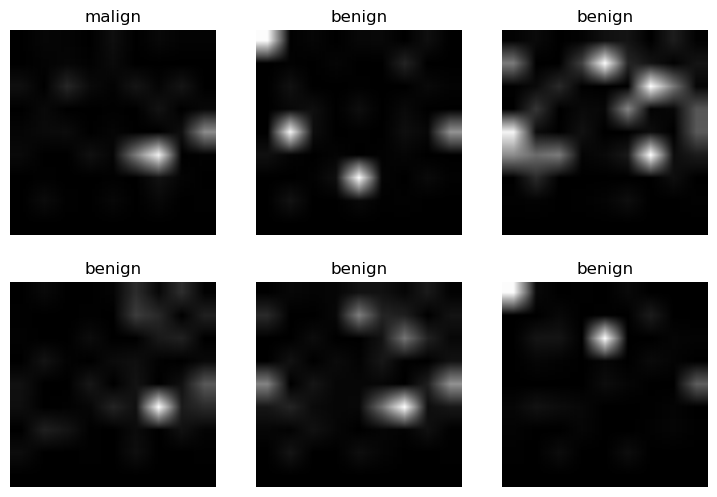

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, #malign or benign
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=128)

dls.show_batch(max_n=6)

In [7]:
roc=RocAucBinary()
learn = vision_learner(dls,resnet34, metrics=roc)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/rtalwaru/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

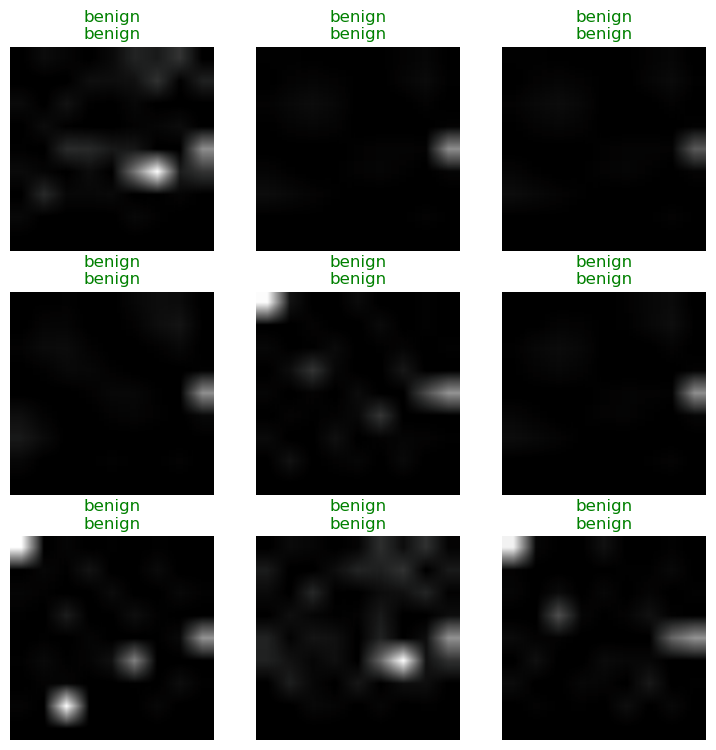

In [8]:
learn.show_results()


In [9]:
path=Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/test')

In [10]:
y_true=[]
pred=[]
for img in get_image_files(path):
    pred.append(learn.predict(img)[0])
    y_true.append(parent_label(img))

In [11]:
y_true=[0 if x=='benign' else 1 for x in y_true]
pred=[0 if x=='benign' else 1 for x in pred]


In [12]:
schemas=["train_2017-test_2017","train_2018-test_2018","train_2017-test_2018","train_2018-test_2017"]
results=[]

In [13]:
from sklearn.metrics import roc_auc_score
results.append(roc_auc_score(y_true, pred))
results

[0.9103078435650845]

In [14]:
def train_and_test(train_path,test_path):
    dls = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label, #malign or benign
        item_tfms=[Resize(192, method='squish')]
    ).dataloaders(train_path, bs=128)

    dls.show_batch(max_n=6)

    roc=RocAucBinary()
    learn = vision_learner(dls,resnet34, metrics=roc)
    learn.fine_tune(3)
    y_true=[]
    pred=[]
    for img in get_image_files(test_path):
        pred.append(learn.predict(img)[0])
        y_true.append(parent_label(img))

    y_true=[0 if x=='benign' else 1 for x in y_true]
    pred=[0 if x=='benign' else 1 for x in pred]
    return roc_auc_score(y_true, pred)


In [ ]:
results.append(train_and_test(Path('/project_ghent/raman/cic-ids2018/subset-5000/flow_images/train'),Path('/project_ghent/raman/cic-ids2018/subset-5000/flow_images/test')))
results

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
results.append(train_and_test(Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train'),Path('/project_ghent/raman/cic-ids2018/subset-5000/flow_images/test')))
results

[0.9103078435650845,
 0.9187426989140312,
 0.5603884023215135,
 0.4757896896354784]

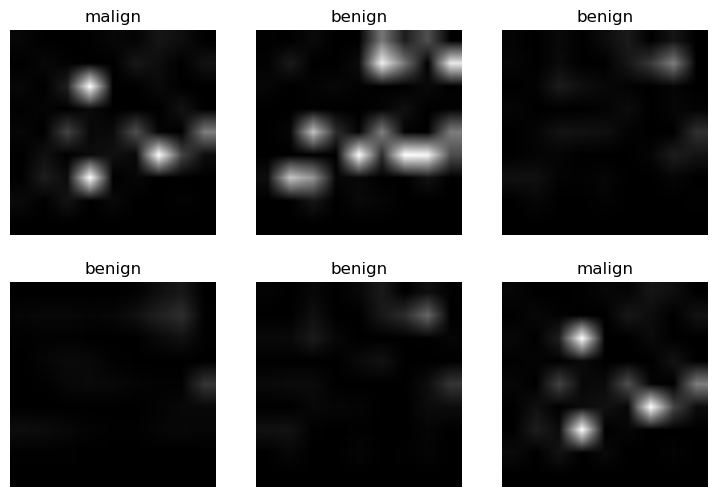

In [17]:
results.append(train_and_test(Path('/project_ghent/raman/cic-ids2018/subset-5000/flow_images/train'),Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/test')))
results

In [18]:
pd.DataFrame(schemas,results)

0
0.910308  train_2017-test_2017
0.918743  train_2018-test_2018
0.560388  train_2017-test_2018
0.475790  train_2018-test_2017